# deeplabV3训练HRSC-Sea，测试HRSC-Land，分析舰船标签效果

标签使用15类目标的旋转框 DOTA-v1.0\train\labelTxt-v1.0\labelTxt

BBAVectors旋转目标检测算法安装部署使用笔记
https://blog.csdn.net/qq_40608730/article/details/119600956

python opencv minAreaRect 生成最小外接矩形
https://blog.csdn.net/lanyuelvyun/article/details/76614872

OpenCV-Python 形状轮廓拟合
https://blog.csdn.net/qq_38828370/article/details/119759530

#1 假设对图片上任意点(x,y)，绕一个坐标点(rx0,ry0)逆时针旋转a角度后的新的坐标设为(x0, y0)，有公式：  
#2 x0= (x - rx0)*cos(a) - (y - ry0)*sin(a) + rx0  
#3 y0= (x - rx0)*sin(a) + (y - ry0)*cos(a) + ry0  
https://www.cnblogs.com/lyj0123/p/15741652.html

python cv2截取不规则区域图片
https://www.cnblogs.com/gmhappy/p/11863932.html

In [1]:
import collections
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F 
from torchvision.models import resnet
from torchvision import datasets, transforms
import numpy as np
import pdb
import matplotlib.pyplot as plt
import sys

### 载入数据

In [2]:
%matplotlib inline
import argparse
def parse_args():
    parser = argparse.ArgumentParser(description='BBAVectors Implementation')
    parser.add_argument('--dataset', type=str, default='dota', help='Name of dataset') #dota格式标签
    parser.add_argument('--data_dir', type=str, default='D:/Datasets/HRSC', help='Data directory')
    parser.add_argument('--batch_size', type=int, default=16, help='Number of batch size')
    parser.add_argument('--num_workers', type=int, default=0, help='Number of workers') #0, BrokenPipeError: [Errno 32] Broken pipe
    parser.add_argument('--phase', type=str, default='train', help='Phase choice= {train, test, eval}')
    parser.add_argument('--input_h', type=int, default=256, help='Resized image height') #256
    parser.add_argument('--input_w', type=int, default=256, help='Resized image width')  #256
    parser.add_argument('--K', type=int, default=500, help='Maximum of objects')
    parser.add_argument('--conf_thresh', type=float, default=0.18, help='Confidence threshold, 0.1 for general evaluation')
    parser.add_argument('--resume', type=str, default='SAMMIE_HRSC_deeplab_model_last.pth',
                        help='Weights resumed in testing and evaluation')
    
    #由于在jupyter notebook中，args不为空。
    args = parser.parse_args(args=[])
    return args

In [3]:
import func_utils
from datasets.dataset_dota import DOTA
from datasets.dataset_hrsc import HRSC

args = parse_args()
print(args.data_dir)

dataset = {'dota': DOTA, 'hrsc': HRSC}
dataset_module = dataset[args.dataset]

D:/Datasets/HRSC


In [4]:
down_ratio = 1
dataset_phase = {'dota': ['train','test'], 'hrsc': ['train', 'test']}

dsets = {x: dataset_module(data_dir=args.data_dir,
                           phase= x,
                           input_h=args.input_h,
                           input_w=args.input_w,
                           down_ratio=down_ratio)
         for x in dataset_phase[args.dataset]}

In [5]:
dsets['train'].cat_ids  # 只有ship = 6

{'plane': 0,
 'baseball-diamond': 1,
 'bridge': 2,
 'ground-track-field': 3,
 'small-vehicle': 4,
 'large-vehicle': 5,
 'ship': 6,
 'tennis-court': 7,
 'basketball-court': 8,
 'storage-tank': 9,
 'soccer-ball-field': 10,
 'roundabout': 11,
 'harbor': 12,
 'swimming-pool': 13,
 'helicopter': 14}

In [6]:
print('dataset num:', len(dsets['train']),len(dsets['test']))

dataset num: 218 1462


In [7]:
import torch
def collater(data):
    out_data_dict = {}
    for name in data[0]:
        out_data_dict[name] = []
    for sample in data:
        for name in sample:
            #pdb.set_trace()
            out_data_dict[name].append(torch.from_numpy(sample[name])) #
    for name in out_data_dict:
        out_data_dict[name] = torch.stack(out_data_dict[name], dim=0)
    return out_data_dict

dsets_loader = {}
dsets_loader['train'] = torch.utils.data.DataLoader(
    dsets['train'],
    batch_size=args.batch_size,
    shuffle=True, ##
    num_workers= args.num_workers, #0,  # 此处必须重新执行              
    pin_memory=False, # True,
    drop_last=True,
    collate_fn=collater)

dsets_loader['test'] = torch.utils.data.DataLoader(
    dsets['test'],
    batch_size=args.batch_size,
    shuffle=False,
    num_workers= args.num_workers, #0,  # 此处必须重新执行              
    pin_memory=False, # True,
    drop_last=True)

In [8]:
next(iter(dsets_loader['train'])).keys(), next(iter(dsets_loader['test'])).keys()

(dict_keys(['input', 'hm', 'reg_mask', 'ind', 'wh', 'reg', 'cls_theta', 'rect', 'cat']),
 dict_keys(['image', 'img_id', 'image_w', 'image_h']))

# 测试单张图像标签

In [9]:
import cv2
#for n in range(150//8):
data_dict = next(iter(dsets_loader['train']))

print([name for name in data_dict])
print(data_dict['input'].shape,data_dict['hm'].shape,data_dict['wh'].shape,data_dict['reg'].shape,args.K)
print(data_dict['rect'].shape, data_dict['cat'].shape)

['input', 'hm', 'reg_mask', 'ind', 'wh', 'reg', 'cls_theta', 'rect', 'cat']
torch.Size([16, 3, 256, 256]) torch.Size([16, 15, 256, 256]) torch.Size([16, 500, 10]) torch.Size([16, 500, 2]) 500
torch.Size([16, 500, 5]) torch.Size([16, 500])


In [10]:
n = 0
img = data_dict['input'].permute([0,2,3,1])[n]
rect =  data_dict['rect'][n,:].cpu().numpy()
heat_map = data_dict['hm'].permute([0,2,3,1])[:,:,:,6][n].numpy()

# 删除标签扩充的0
idx = np.argwhere(np.all(rect[:, ...] == 0, axis=1))
rect = np.delete(rect, idx, axis=0)
print("标签尺寸: ",rect.shape)

标签尺寸:  (1, 5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


"\ncv2.imshow('img',image)\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n"

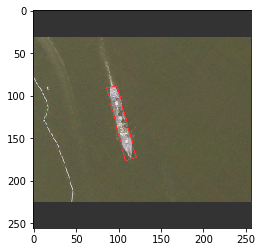

In [11]:
image = img.numpy()
boxList= []

for pts in rect:
    x,y,w,h,angle = pts[:5]
    box = cv2.boxPoints(((x,y),(w,h),angle)) # 获取最小外接矩形的4个顶点坐标(ps: cv2.boxPoints(rect) for OpenCV 3.x)
    box = np.int0(box)
    boxList.append(box)

image = cv2.drawContours(image.copy()+0.5, boxList, -1, (255, 0, 0), 1)
plt.imshow(image+0.2)

"""
cv2.imshow('img',image)
cv2.waitKey(0)
cv2.destroyAllWindows()
"""

In [12]:
def rectCrop(img, rect ):
    # 截取img中rect标签的区域
    #img(m,n,3);  rect(x,y,wh,h,ang) 
    # return img*mask
    
    box = cv2.boxPoints(((float(rect[0]),float(rect[1])),
                         (float(rect[2]),float(rect[3])), float(rect[4]) ))
    box = np.int0(box)
    mask = np.zeros(img.shape)
    cv2.fillPoly(mask, [box], (1,1,1))
    if type(img) == torch.Tensor:
        mask = torch.tensor(mask,device=img.device)
    return img * mask

torch.Size([16, 500, 5])
tensor([103.6611, 132.5786,  88.4958,  12.5859,  75.2405])


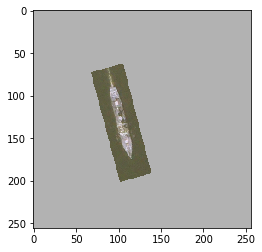

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([136.4581, 125.4626,  19.4210,  61.2553,  76.4119])


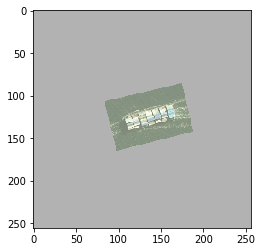

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 56.9515, 157.0396,   7.9443,  23.6274,  62.2096])


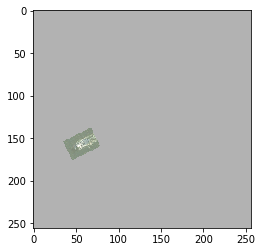

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([179.9460, 169.4472,  58.4443,  15.0230,  32.7874])


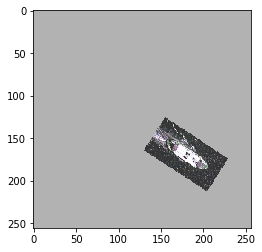

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([125.1362, 140.8249,  55.8865,  10.5683,  34.4691])


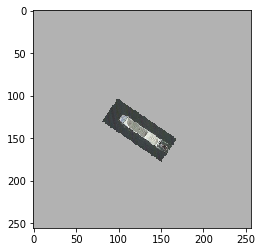

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([190.2854, 147.8186,  15.9083,  69.3343,  36.3045])


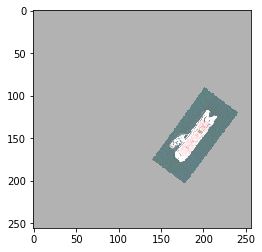

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([154.5272, 161.4809,  18.2419,  95.0995,  76.6794])


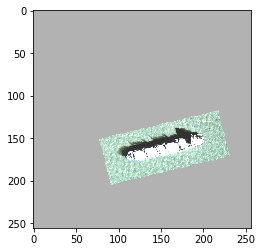

tensor([ 76.1984, 116.6371,  91.4933,  15.7100,  37.4152])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


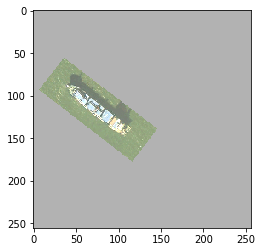

In [13]:
import itertools

print(data_dict['rect'].shape)
n = 0

for bat,num in itertools.product(range(data_dict['rect'].shape[0]),
                       range(data_dict['rect'].shape[1])):
    rect = data_dict['rect'][bat,num]
    if sum(rect) <= 0:
        continue
    print( rect ) # rect 非0
    
    img = data_dict['input'][bat].permute([1,2,0])
    
    Ew,Eh = (3, 1.5) #扩大宽和长，包含周围环境
    if rect[2] > rect[3]:
        w,h = rect[2] * Eh,rect[3] * Ew
    else:
        w,h = rect[2] * Ew,rect[3] * Eh
    
    target = rectCrop(img, (rect[0],rect[1],w, h,rect[4])  )

    plt.imshow( target +0.7 ) # img
    plt.show()

In [14]:
cv2.destroyAllWindows()

# 配置模型和损失函数 deeplabv3_resnet50

In [15]:
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False, progress=True, num_classes=3, aux_loss=None)

In [16]:
print(args.resume)
model.load_state_dict(torch.load(args.resume))

SAMMIE_HRSC_deeplab_model_last.pth


<All keys matched successfully>

In [17]:
# model.load_state_dict(torch.load(args.resume)) #加载模型参数
device = torch.device('cpu')
model.load_state_dict(torch.load('SAMMIE_Sea_deeplab_model_last.pth', map_location=device)) #加载模型参数
#model.load_state_dict(torch.load('SAMMIE_HRSC_deeplab_model_last.pth', map_location=device)) #加载模型参数

<All keys matched successfully>

In [18]:
X_example = data_dict['input'].cpu()
X_example = (X_example)  #data_transform

X_example.shape

y = model(X_example)['out']
y.shape

torch.pow(X_example - y,2).sum()
torch.tensor(X_example.shape).cumprod(dim=0)[-1]

tensor(3145728)

In [19]:
# 损失和优化函数
class SquaredErrorLoss(nn.Module):
    def __init__(self):
        super(SquaredErrorLoss, self).__init__()
        
    def forward(self, X, Y):
        input_shape = torch.tensor(X.size())
        Error = torch.pow(X - Y, 2).sum() / input_shape.cumprod(dim=0)[-1]
        return Error
    

loss_f = SquaredErrorLoss()  #torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

loss_f(X_example, y)

tensor(0.1822, grad_fn=<DivBackward0>)

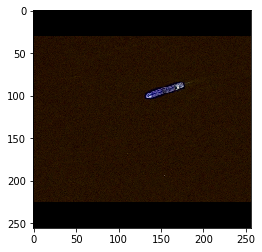

In [20]:
plt.imshow(X_example[1].permute([1,2,0])+0.5 )

In [21]:
pred = torch.mean(pow(X_example - y,2), dim=[1])
pred.mean(dim=[1,2])

tensor([0.2168, 0.2370, 0.1161, 0.1682, 0.2124, 0.2211, 0.1481, 0.1684, 0.2274,
        0.0987, 0.2275, 0.1813, 0.1787, 0.2232, 0.1103, 0.1807],
       grad_fn=<MeanBackward1>)

In [22]:
import collections
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import time
import pdb
import os

In [24]:
# 配置GPU，开始进行训练
Use_gpu = torch.cuda.is_available()

if Use_gpu:
    print( torch.cuda.get_device_properties(device = 0) )
    model = model.cuda()
    
# 配置多GPU
if torch.cuda.device_count() > 1:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

_CudaDeviceProperties(name='NVIDIA GeForce GTX 1080', major=6, minor=1, total_memory=8192MB, multi_processor_count=20)
Let's use 2 GPUs!


In [44]:
epoch_n = 400
time_open = time.time()
f = open('Loss_log.txt', 'a+')

for epoch in range(epoch_n):
    print("Epoch {}/{}".format(epoch, epoch_n - 1))
    print("-"*10)
    
    for phase in ["train"]: #, "valid"
        if phase == "train":
            print("Training...")
            model.train(True)
        else:
            # 把BatchNormalization和DropOut固定住，不会取平均，而是用训练好的值
            print("Valid...")
            model.train(False) 
            
        running_loss = 0.0
        running_corrects = 0.0
        ship_error = []
        
        # 组合为一个索引序列
        for batch, data_dict in enumerate(dsets_loader['train'], start = 1):
            
            X = (data_dict['input']) #data_transform添加预处理
            y = data_dict['hm']
            
            if Use_gpu:
                X, y = Variable(X.cuda()), Variable(y.cuda())
            else:
                X, y = Variable(X), Variable(y)
            
            y_pred = model.forward(X)['out']
            error_map = torch.pow(X - y_pred, 2)
            pred = torch.mean(error_map, dim=[1])
            
            # Squared Error Loss
            loss = loss_f(y_pred, X) 
            
            # 对参数梯度的归零
            optimizer.zero_grad()
            if phase == "train":
                # 计算反向传播梯度值 P167
                loss.backward() 
                # 对节点的参数进行梯度更新 P169
                optimizer.step()
                
            running_loss += float(loss.data)
            running_corrects += float(torch.sum(pred.mean(dim=[1,2])))
            
            if batch%10000 == 0 and phase == "train":
                print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4f}"
                      .format(batch, running_loss/batch, 100*running_corrects/batch/ len(pred)))
                print("Current time {:.2f} min".format((time.time() - time_open)/60))
            """
            # 分析舰船位置的结果
            # error_map = pow(y_pred - X, 2) #sl 
            for bat,num in itertools.product(range(data_dict['rect'].shape[0]),
                       range(data_dict['rect'].shape[1])):
                rect = data_dict['rect'][bat,num]
                if sum(rect) <= 0:
                    continue
                #print(rect)
                Ew,Eh = (3, 1.5) #扩大宽和长，包含周围环境
                if rect[2] > rect[3]:
                    w,h = rect[2] * Eh,rect[3] * Ew
                else:
                    w,h = rect[2] * Ew,rect[3] * Eh
                img = error_map[bat].permute([1,2,0])
                target = rectCrop(img, (rect[0],rect[1],w, h,rect[4]))
                ship_error.append( float(target.sum()/((target>0).sum())) )
                """
                
        epoch_loss = running_loss*dsets_loader['train'].batch_size/len(dsets_loader['train'])
        epoch_acc = 100*running_corrects/len(dsets_loader['train'])
        #epoch_acc = np.mean(ship_error)
        
        print("{} Loss:{:.6f}  Acc:{:.6f}%".format(phase, epoch_loss, epoch_acc))
        f.write("{} Loss:{:.6f}  Acc:{:.6f}%\n".format(phase, epoch_loss, epoch_acc))
        time_end = time.time() - time_open
        print("Finish time {:.2f} min".format(time_end/60))

f.close()
if torch.cuda.device_count() > 1:
    torch.save(model.module.state_dict(), args.resume)
else:
    torch.save(model.state_dict(), args.resume)

Epoch 0/399
----------
Training...


C:\ProgramData\Anaconda3\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


train Loss:2.601000  Acc:260.100038%
Finish time 0.24 min
Epoch 1/399
----------
Training...
train Loss:2.310465  Acc:231.046532%
Finish time 0.44 min
Epoch 2/399
----------
Training...
train Loss:2.065321  Acc:206.532111%
Finish time 0.65 min
Epoch 3/399
----------
Training...
train Loss:1.809153  Acc:180.915298%
Finish time 0.85 min
Epoch 4/399
----------
Training...
train Loss:1.597673  Acc:159.767341%
Finish time 1.05 min
Epoch 5/399
----------
Training...
train Loss:1.252144  Acc:125.214406%
Finish time 1.26 min
Epoch 6/399
----------
Training...
train Loss:0.971544  Acc:97.154436%
Finish time 1.46 min
Epoch 7/399
----------
Training...
train Loss:0.716420  Acc:71.641980%
Finish time 1.67 min
Epoch 8/399
----------
Training...
train Loss:0.568583  Acc:56.858298%
Finish time 1.87 min
Epoch 9/399
----------
Training...
train Loss:0.493666  Acc:49.366588%
Finish time 2.08 min
Epoch 10/399
----------
Training...
train Loss:0.429420  Acc:42.942011%
Finish time 2.28 min
Epoch 11/399
---

train Loss:0.075772  Acc:7.577158%
Finish time 19.41 min
Epoch 89/399
----------
Training...
train Loss:0.076109  Acc:7.610945%
Finish time 19.62 min
Epoch 90/399
----------
Training...
train Loss:0.075921  Acc:7.592106%
Finish time 19.83 min
Epoch 91/399
----------
Training...
train Loss:0.078386  Acc:7.838564%
Finish time 20.04 min
Epoch 92/399
----------
Training...
train Loss:0.073743  Acc:7.374287%
Finish time 20.25 min
Epoch 93/399
----------
Training...
train Loss:0.073565  Acc:7.356491%
Finish time 20.46 min
Epoch 94/399
----------
Training...
train Loss:0.080070  Acc:8.007040%
Finish time 20.67 min
Epoch 95/399
----------
Training...
train Loss:0.072435  Acc:7.243530%
Finish time 20.91 min
Epoch 96/399
----------
Training...
train Loss:0.071927  Acc:7.192696%
Finish time 21.13 min
Epoch 97/399
----------
Training...
train Loss:0.074889  Acc:7.488925%
Finish time 21.34 min
Epoch 98/399
----------
Training...
train Loss:0.069749  Acc:6.974868%
Finish time 21.55 min
Epoch 99/399


train Loss:0.045328  Acc:4.532839%
Finish time 56.13 min
Epoch 177/399
----------
Training...
train Loss:0.045697  Acc:4.569742%
Finish time 57.06 min
Epoch 178/399
----------
Training...
train Loss:0.046388  Acc:4.638757%
Finish time 57.99 min
Epoch 179/399
----------
Training...
train Loss:0.045018  Acc:4.501810%
Finish time 58.93 min
Epoch 180/399
----------
Training...
train Loss:0.047066  Acc:4.706644%
Finish time 59.86 min
Epoch 181/399
----------
Training...
train Loss:0.044638  Acc:4.463817%
Finish time 60.79 min
Epoch 182/399
----------
Training...
train Loss:0.046969  Acc:4.696905%
Finish time 61.73 min
Epoch 183/399
----------
Training...
train Loss:0.045731  Acc:4.573136%
Finish time 62.66 min
Epoch 184/399
----------
Training...
train Loss:0.046392  Acc:4.639155%
Finish time 63.60 min
Epoch 185/399
----------
Training...
train Loss:0.041725  Acc:4.172471%
Finish time 64.53 min
Epoch 186/399
----------
Training...
train Loss:0.044188  Acc:4.418753%
Finish time 65.47 min
Epo

train Loss:0.039615  Acc:3.961506%
Finish time 137.44 min
Epoch 264/399
----------
Training...
train Loss:0.036781  Acc:3.678148%
Finish time 138.38 min
Epoch 265/399
----------
Training...
train Loss:0.036312  Acc:3.631154%
Finish time 139.31 min
Epoch 266/399
----------
Training...
train Loss:0.035901  Acc:3.590082%
Finish time 140.32 min
Epoch 267/399
----------
Training...
train Loss:0.036624  Acc:3.662441%
Finish time 141.25 min
Epoch 268/399
----------
Training...
train Loss:0.035207  Acc:3.520742%
Finish time 142.19 min
Epoch 269/399
----------
Training...
train Loss:0.038357  Acc:3.835713%
Finish time 143.13 min
Epoch 270/399
----------
Training...
train Loss:0.035112  Acc:3.511226%
Finish time 144.07 min
Epoch 271/399
----------
Training...
train Loss:0.039332  Acc:3.933193%
Finish time 145.01 min
Epoch 272/399
----------
Training...
train Loss:0.038117  Acc:3.811718%
Finish time 145.94 min
Epoch 273/399
----------
Training...
train Loss:0.036814  Acc:3.681362%
Finish time 146

train Loss:0.033743  Acc:3.374328%
Finish time 169.43 min
Epoch 351/399
----------
Training...
train Loss:0.032120  Acc:3.212023%
Finish time 169.62 min
Epoch 352/399
----------
Training...
train Loss:0.032615  Acc:3.261545%
Finish time 169.82 min
Epoch 353/399
----------
Training...
train Loss:0.031362  Acc:3.136153%
Finish time 170.03 min
Epoch 354/399
----------
Training...
train Loss:0.031588  Acc:3.158815%
Finish time 170.22 min
Epoch 355/399
----------
Training...
train Loss:0.030340  Acc:3.033950%
Finish time 170.42 min
Epoch 356/399
----------
Training...
train Loss:0.032251  Acc:3.225084%
Finish time 170.61 min
Epoch 357/399
----------
Training...
train Loss:0.033141  Acc:3.314082%
Finish time 170.81 min
Epoch 358/399
----------
Training...
train Loss:0.031528  Acc:3.152808%
Finish time 171.01 min
Epoch 359/399
----------
Training...
train Loss:0.031356  Acc:3.135610%
Finish time 171.20 min
Epoch 360/399
----------
Training...
train Loss:0.030401  Acc:3.040130%
Finish time 171

In [ ]:
import matplotlib.pyplot as plt
from skimage import io

n = 5
img = np.array(pow((X-y_pred),2)[n,:,:,:].detach().cpu().mean(dim=0))
io.imshow(np.array( X[n,:,:,:].detach().cpu().permute([1,2,0])))
plt.figure()
plt.imshow(img, cmap=plt.cm.jet)
plt.colorbar()

In [ ]:
pow((X-y_pred),2)[5,:,:,:].detach().cpu().mean(dim=0)

# 图像分割，陆地区域对比测试

In [64]:
import os
args.data_dir = 'D:/Datasets/HRSC'
image_set_index_file = os.path.join(args.data_dir, 'Segmentations.txt')

with open(image_set_index_file, 'r') as f:
    lines = f.readlines()
segm_lists = [line.strip() for line in lines]

In [65]:
model.train(False) 

land_error = []
ship_error = []
sea_error = []

for index in range(len(segm_lists)):
    filename = segm_lists[index]
    imgFile = os.path.join(args.data_dir,'images',filename +'.png')
    labelFile = os.path.join(args.data_dir,'labelTXT',filename+'.txt')
    segmFile = os.path.join(args.data_dir,'Segmentations',filename+'.png')
    
    image = cv2.imread(imgFile)
    segm  = cv2.imread(segmFile)
    annotation = load_annotation(image, labelFile)
    
    # 预处理image
    image = cv2.resize(image, [args.input_h, args.input_w])
    image = np.asarray(np.clip(image, a_min=0., a_max=255.), np.float32)
    #image = self.image_distort(np.asarray(image, np.float32))
    image = np.asarray(np.clip(image, a_min=0., a_max=255.), np.float32)
    image = np.transpose(image / 255. - 0.5, (2, 0, 1))
    
    # 预处理 Segmentation，提取白色陆地区域
    segm = cv2.resize(segm, [args.input_h, args.input_w])
    idx = np.where((segm[:,:,0]>250)*(segm[:,:,1]>250)*(segm[:,:,2]>250))
    segmLand = np.zeros(segm.shape)
    segmLand[idx] = (1,1,1)
    #plt.imshow((segmLand+0.5) * np.transpose(image+0.5, (1,2,0)) )
    
    # 预处理 Segmentation，提取黑色海洋区域
    segm = cv2.resize(segm, [args.input_h, args.input_w])
    idx = np.where((segm[:,:,0]<5)*(segm[:,:,1]<5)*(segm[:,:,2]<5))
    segmSea = np.zeros(segm.shape)
    segmSea[idx] = (1,1,1)
    
    # 正向传播
    device = next(model.parameters()).device
    X = torch.tensor(image,device=device).unsqueeze(0)
    segm = torch.tensor(segmLand, device=device)
    
    y_pred = model.forward(X)['out']
    error_map = torch.pow(X - y_pred, 2)
    pred = torch.mean(error_map, dim=[1])
    if ((index+1)/len(segm_lists)*100)%25 == 0:
        print("proceeding {}%, Error Map: {}".format(index*100//len(segm_lists),
                                                 error_map.mean()))
    
    boxList= []
    maskShip = np.zeros(np.transpose(image,[1,2,0]).shape)
    for pts in annotation['rect']:
        #print(pts)
        x,y,w,h, angle= pts[:5]
        Ew,Eh = (3, 1.5) # #扩大宽和长，包含周围环境
        if w > h:
            w,h = w * Eh, h * Ew
        else:
            w,h = w * Ew, h * Eh
        # 获取最小外接矩形的4个顶点坐标
        box = cv2.boxPoints(((x,y),(w,h),angle)) 
        box = np.int0(box)
        boxList.append(box)
        mask = np.zeros(np.transpose(image,[1,2,0]).shape)
        cv2.fillPoly(mask, [box], (1,1,1))
        maskShip = maskShip + mask
    maskShip[maskShip>1] = 1
    
    
    
    target = error_map[0].permute([1,2,0]).cpu().detach().numpy() * maskShip
    ship_error.append( float(target.sum()/((target>0).sum())) )
    
    target = error_map[0].permute([1,2,0]).cpu().detach().numpy() * segmLand
    land_error.append( float(target.sum()/((target>0).sum())) )
    
    target = error_map[0].permute([1,2,0]).cpu().detach().numpy() * segmSea
    sea_error.append( float(target.sum()/((target>0).sum())) )
    
    """
    image = cv2.drawContours( np.transpose(image,[1,2,0])+0.5, boxList, -1, (0,255,0), 1)
    cv2.imshow('img',image * (segmLand + maskShip*0.5 + 0.1))
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    """
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars


proceeding 24%, Error Map: 0.0493282824754715
proceeding 49%, Error Map: 0.060987334698438644
proceeding 74%, Error Map: 0.0391850620508194


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars


proceeding 99%, Error Map: 0.024747086688876152


In [66]:
import pandas as pd
count_error =  pd.DataFrame({'list':segm_lists,'ship':ship_error, 'land':land_error, 'sea':sea_error} )
count_error = count_error.sort_values(by="ship",axis=0,ascending=False,inplace=False)
count_error.head()

,list,ship,land,sea
367,100001512,0.237817,0.386133,0.042872
104,100000857,0.172086,0.139636,0.045676
37,100000707,0.172007,NaN,0.060910
59,100000771,0.144822,0.229292,0.035366
85,100000826,0.128203,0.138830,0.020759


In [67]:
count = count_error.dropna(axis=0) # 除去nan
print(len(count))
print( "land>ship ratio: {}".format(sum(count['land'] > count['ship']) / len(count)) )
print( "land/ship average: {}".format(np.mean(count['land'] / count['ship']) ))

402
land>ship ratio: 0.917910447761194
land/ship average: 1.6478593454744597


Land Error: 0.06937515425028831
Ship Error: 0.021895576254239435
Sea Error: 0.026065739633239316


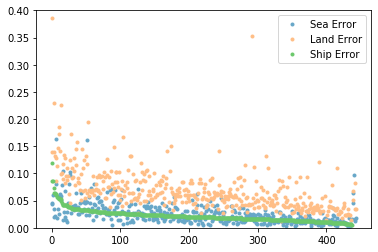

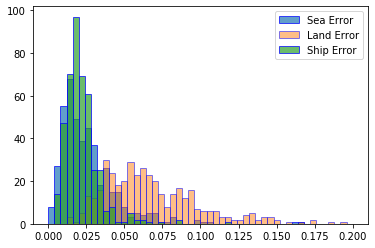

In [71]:
print('Land Error:', count_error['land'].dropna().mean())
print('Ship Error:', count_error['ship'].dropna().mean()*0.5)
print('Sea Error:', count_error['sea'].dropna().mean())
plt.plot( count_error['sea'].values,'r.',label='Sea Error',color=(103/255,167/255,200/255) )
plt.plot( count_error['land'].values,'b.',label='Land Error',color=(255/255,190/255,134/255) )
plt.plot( count_error['ship'].values,'m.',label='Ship Error',color=(107/255,200/255,107/255) )
plt.ylim(0,0.4)
plt.legend()

plt.figure()
plt.hist( count_error['sea'],range=[0,0.2], bins=50,edgecolor='b',alpha=0.7,label='Sea Error');
plt.hist(count_error['land'],range=[0,0.2],bins = 50,edgecolor='b',alpha=0.5,label='Land Error');
plt.hist( count_error['ship'],range=[0,0.2], bins=50,edgecolor='b',alpha=0.7,label='Ship Error');
plt.legend()